# Using online job postings to improve data science resume

## Problem Statement
I want to find out what are the skills of data scientist not represented in my resume draft.  
In order to improve the **CV** and start applying for the jobs.
There is folder with all the job listings in HTML format.  
Goal is to extract common data science skills and compare these skiils to the resume.

<img src="https://miro.medium.com/v2/resize:fit:4800/format:webp/1*rsJsA9wsN2Y5-o7HsItJ2A.jpeg"
     width="500"
     height="300">


## Plan

To achieve the goal we will do the following:

1. Parse out all the text from the HTML files.
2. Learn how job skills are commonly described in online postings.
3. Filter irrelevant postings.
4. Cluster the job skills within the relevant postings and visualize.
5. Compare the clustered skills and our resume content.


## Packages

In [2]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup as bs
from IPython.core.display import HTML
from sklearn.feature_extraction.text import TfidfVectorizer

## Data Extraction

In [3]:
import zipfile

html_contents = []

with zipfile.ZipFile("job_postings.zip", "r") as z:
    for name in sorted(z.namelist()):
        if name.endswith(".html"):
            with z.open(name) as f:
                html_contents.append(f.read().decode("utf-8"))

print(f"{len(html_contents)} HTML files have been loaded")


1458 HTML files have been loaded


Let's parse and store the parsed results in **soup_objects** list

In [4]:
soup_objects = []
for html in html_contents:
    soup = bs(html)
    assert soup.title is not None
    assert soup.body is not None 
    soup_objects.append(soup)
html_dict = {'Title':[], 'Body':[]}
for soup in soup_objects:
    title = soup.find('title').text
    body = soup.find('body').text
    html_dict['Title'].append(title)
    html_dict['Body'].append(body)

df_jobs = pd.DataFrame(html_dict)
summary = df_jobs.describe()
display(summary)

,Title,Body
count,1458,1458
unique,1364,1458
top,"Data Scientist - New York, NY","Data Scientist - Beavercreek, OH\nData Scienti..."
freq,13,1


There are 1364 unique titles out of 1458, the remaining 94 titles are duplicates.  

The most common title repeated 13 times.  

All 1458 bodies are unique, so none of the job postings occur more than once, even if some postings share common title.  
  
Now let's explore HTML content in more detail, the aim is to determine how jobs skills are described in the files.

In [5]:
# Explore the skill desriptions
assert len(set(html_contents)) == len(html_contents)
display(HTML(html_contents[3]))

There are usually 2 subsections, 1 for Responsibilities and 1 for Qualifications.  
  
They are not that different, yet qualifications focus on tools and concepts, while responsibilities are covering actions to be performed on the job.  
  
Let's divide posting description into 2 parts:
  
  
A. Initial job summary.  

B. List of skills required to get a job 

Do these types of skills desriptions also appear in other job postings.  
Let' extract the bullets from each of parsed HTML files. 
Bullet point is taged in "li" and appears as dot in the html file.

In [6]:
# Extract a list of bullet points from soup object by calling following function
df_jobs['Bullets'] = [[bullet.text.strip() for bullet in soup.find_all('li') ]for soup in soup_objects]


We created new col "Bullets" to store all the bullet points, however, it may also be possible that majority of the job postings simply don't contain any!   
  
Let's find out the percentages of postings that actually contain bulleted text.  
  
If it's too low it is worth changing the approach of the analysis.

In [7]:
bulleted_post_count = 0
for bullet_list in df_jobs.Bullets:
    if bullet_list:
        bulleted_post_count += 1
percent_bulleted = 100 * bulleted_post_count / df_jobs.shape[0]
print(f"{percent_bulleted:.2f}% of the postings contain bullet points ")


90.53% of the postings contain bullet points 


Okay, next step is to understand whether most of these bullets focus on skills.  
For that matter let's print out top-ranked words in their text. 
For ranking we will use **Term Frequency Inverse Document Frequency**

### **How TFIDF Created**
TF-IDF is the product of two distinct metrics designed to balance local importance and global rarity:

1.  **Term Frequency (TF):** Measures how frequently a word appears in a specific document.
    *   *Core Idea:* If a word appears often, it is likely important to that document’s topic.
    *   *Formula:* $\text{TF}(t, d) = \frac{\text{Count of term } t \text{ in document } d}{\text{Total number of words in document } d}$.
2.  **Inverse Document Frequency (IDF):** Measures how rare a word is across the entire corpus.
    *   *Core Idea:* Common words (like "the" or "is") appear in many documents and provide little unique information, so they are penalized with a lower weight.
    *   *Formula:* $\text{IDF}(t) = \log\left(\frac{\text{Total number of documents}}{\text{Number of documents containing term } t}\right)$.
3.  **Final Score:** $\text{TF-IDF}(t, d) = \text{TF}(t, d) \times \text{IDF}(t)$.


In [8]:
def rank_words(text_list):
    vectorizer = TfidfVectorizer(stop_words='english')
    tfdidf_matrix = vectorizer.fit_transform(text_list).toarray()
    df = pd.DataFrame({'Words': vectorizer.get_feature_names_out(),
                       "Summed TFIDF": tfdidf_matrix.sum(axis=0)})
    sorted_df = df.sort_values('Summed TFIDF', ascending=False)
    return sorted_df
all_bullets = []
for bullet_list in df_jobs.Bullets:
    all_bullets.extend(bullet_list)
sorted_df = rank_words(all_bullets)
print(sorted_df[:5].to_string(index=False))

     Words  Summed TFIDF
experience    878.030398
      data    842.978780
    skills    440.780236
      work    371.684232
   ability    370.969638


Terms such as **skills** and **ability** appear among the top five bulleted words.
Most likely the bullets correspond to individual job skills.  
How do these bulleted words compare to the remaining words in each job posting?  
  
  
We iterate over the body of each posting and delete any bulleted lists using Beautiful Soup *decompose* method. 
Then we extract the remaining body text and store it in a non_bullets list. 
Finally, we apply rank_words function that lists and display the top five non-bullet words.


In [9]:
non_bullets = []
for soup in soup_objects:
    body = soup.body
    for tag in body.find_all('li'):
        tag.decompose()
    non_bullets.append(body.text)
sorted_df = rank_words(non_bullets)
print(sorted_df[:5].to_string(index=False))

     Words  Summed TFIDF
      data     99.111312
      team     39.175041
      work     38.928948
experience     36.820836
  business     36.140488


The words **skills** and **ability** are no longer present in the ranked output. 
They have been replaced by the words **business** and **team**. Thus, non-bulleted text appears to be less skill oriented.  
  
Words *data*, *experience* and *work* top ranked words that are shared between bullets and non-bulleted.  
Strangely words **science** and **scientist** are missing.  

Logic question arises, do some posts pertain to data-driven jobs aren't directly *data science* jobs? 
 

Let's iterate over all the titles across all jobs and checking if each title mentions a data science position.  
Then, we will measure the percentages of jobs where data science and data scientist are missing from the titles.

In [10]:
# we match our terms to the title using regular expressions.
regex = r'Data Scien(?:ce|tist)'
df_non_ds_jobs = df_jobs[~df_jobs.Title.str.contains(regex, case=False)]
percent_non_ds = 100 * df_non_ds_jobs.shape[0] / df_jobs.shape[0]
print(f'{percent_non_ds:.2f}% of the job postings titles do not mention a \n'
      f'data science position. Below is a sample of such titles:\n')
for title in df_non_ds_jobs.Title[:10]:
    print(title)


64.33% of the job postings titles do not mention a 
data science position. Below is a sample of such titles:

Patient Care Assistant / PCA - Med/Surg (Fayette, AL) - Fayette, AL
Data Manager / Analyst - Oakland, CA
Scientific Programmer - Berkeley, CA
JD Digits - AI Lab Research Intern - Mountain View, CA
Operations and Technology Summer 2020 Internship-West Coast - Universal City, CA
Data and Reporting Analyst - Olympia, WA 98501
Senior Manager Advanced Analytics - Walmart Media Group - San Bruno, CA
Data Specialist, Product Support Operations - Sunnyvale, CA
Deep Learning Engineer - Westlake, TX
Research Intern, 2020 - San Francisco, CA 94105


We can notice that many of these postings are still referring to data science, however worded differently.  
For example, *data specialist* or *scientific programmer*. Moreover, some positions are research internships.  
  
  
Which can be assured to be data-centric. Nevertheless, some positions are irrelevant such as managerial positions.  
First posting contains word PCA, maybe during data collection crawler erroneously confused it with an PCA algorithm.

The erroneous posting contains skills that we lack and have no interest in obtaining.  
Thus, they should be removed.

In [11]:
# if not they will cause noise in our analysis
bullets = df_non_ds_jobs.Bullets.iloc[0]
for i, bullet in enumerate(bullets[:5],1):
    print(f"{i}: {bullet.strip()}")
    

1: Provides all personal care services in accordance with the plan of treatment assigned by the registered nurse
2: Accurately documents care provided
3: Applies safety principles and proper body mechanics to the performance of specific techniques of personal and supportive care, such as ambulation of patients, transferring patients, assisting with normal range of motions and positioning
4: Participates in economical utilization of supplies and ensures that equipment and nursing units are maintained in a clean, safe manner
5: Routinely follows and adheres to all policies and procedures


These skills above are not of our interest. We need to delete them from the dataset.  
The strategy is as follows: 
1. Obtain relevant job postings that partially match our existing skill set
2. Examine which bullet points in these postings are missing from our existing skill set.

### Filtering jobs by relevance

In [12]:
# let's load our artificial resume
resume = open('resume.txt','r').read()
print(resume)

Experience

1. Developed probability simulations using NumPy.
2. Assessed online ad-clicks for statistical significance using Permutation testing.
3. Analyzed disease outbreaks using common clustering algorithms.

Additional Skills

1. Data visualization using Matplotlib.
2. Statistical analysis using SciPy.
3. Processing structured tables using Pandas.
4. Executing K-Means clustering and DBSCAN clustering using Scikit-Learn.
5. Extracting locations from text using GeonamesCache.
6. Location analysis and visualization using GeonamesCache and Basemap.
7. Dimensionality reduction with PCA and SVD, using Scikit-Learn.
8. NLP analysis and text topic detection using Scikit-Learn.


In the same manner we can store the table of contents in a variable *table_of_contents* 

In [13]:
table_of_contents = open('table_of_contents.txt','r').read()
existing_list = resume + table_of_contents

Task is to compute the text_similarity between each job posting and our existing skills.  
In other words, we want to compute all similarities between *df_jobs.Body* and *existing_skills*.  
  
Computation requires texts' vectorization of df_jobs.Body together with existing_skills.  
That will ensure that vectors share the same vocabulary.  
  
Afterwards, we combine our job posts and our skill string into a single list of texts and vectorize these texts using scikit-learn
**TfidfVectorizer** 

In [14]:
text_list = df_jobs.Body.tolist() + [existing_list]
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(text_list).toarray()


The final matrix row (tfidf_matrix[-1]) corresponds to existing skillset and all other rows correspond to the job postings.  
We can compute *cosine* similarities between the jobs postings and existing_skills.

### How cosine similiraty  calculated

`TfidfVectorizer` normalizes vectors by default using **L2 normalization**.  
This means each TF-IDF vector has unit length:

$$
\|v\| = 1
$$

The cosine similarity between two vectors **A** and **B** is defined as:

$$
\text{cosine\_similarity}(A, B) =
\frac{A \cdot B}{\|A\| \|B\|}
$$

Since both vectors are normalized:

$$
\|A\| = \|B\| = 1
$$

The formula simplifies to:

$$
\text{cosine\_similarity}(A, B) = A \cdot B
$$

Therefore, when using normalized TF-IDF vectors, the **dot product is exactly the cosine similarity**.


In [15]:
cosine_similarity = tfidf_matrix[:-1] @ tfidf_matrix[-1]

Cosine similarity captures the text overlap between our existing skills and the posted jobs.  
Jobs with greater overlap are more relevant and jobs with lesser overlap are less relevant.  
  
Thus, we can use cosine similarities to rank jobs by relevance.  
First we will store it in *Relevance* column in **df_jobs** and then sort by it in descending order.  
  
Finally, we print the least relevant job titles and examine whehter they have anything to do with *data science*

In [16]:
df_jobs['Relevance'] = cosine_similarity
sorted_df_jobs = df_jobs.sort_values("Relevance", ascending=False)
for title in sorted_df_jobs[-20:].Title:
    print(title)

Data Analyst Internship (8 month minimum) - San Francisco, CA
Leadership and Advocacy Coordinator - Oakland, CA 94607
Finance Consultant - Audi Palo Alto - Palo Alto, CA
RN - Hattiesburg, MS
Configuration Management Specialist - Dahlgren, VA
Deal Desk Analyst - Mountain View, CA
Dev Ops Engineer AWS - Rockville, MD
Web Development Teaching Assistant - UC Berkeley (Berkeley) - Berkeley, CA
Scorekeeper - Oakland, CA 94612
Direct Care - All Experience Levels (CNA, HHA, PCA Welcome) - Norwell, MA 02061
Director of Marketing - Cambridge, MA
Certified Strength and Conditioning Specialist - United States
PCA - PCU Full Time - Festus, MO 63028
Performance Improvement Consultant - Los Angeles, CA
Patient Services Rep II - Oakland, CA
Lab Researcher I - Richmond, CA
Part-time instructor of Statistics for Data Science and Machine Learning - San Francisco, CA 94105
Plant Engineering Specialist - San Pablo, CA
Page Not Found - Indeed Mobile
Director of Econometric Modeling - External Careers


We can disregard 20 lowest-ranking jobs in the sorted table.  

Below are top 20 relevant job titles. 

In [17]:
for title in sorted_df_jobs[:20].Title:
    print(title)

Chief Data Officer - Culver City, CA 90230
Data Scientist - Beavercreek, OH
Data Scientist Population Health - Los Angeles, CA 90059
Data Scientist - San Diego, CA
Data Scientist - Beavercreek, OH
Senior Data Scientist - New York, NY 10018
Data Architect - Raleigh, NC 27609
Data Scientist (PhD) - Spring, TX
Data Science Analyst - Chicago, IL 60612
Associate Data Scientist (BS / MS) - Spring, TX
Data Scientist - Streetsboro, OH 44241
Data Scientist - Los Angeles, CA
Sr Director of Data Science - Elkridge, MD
2019-57 Sr. Data Scientist - Reston, VA 20191
Data Scientist (PhD) - Intern - Spring, TX
Sr Data Scientist. - Alpharetta, GA 30004
Data Scientist GS 13/14 - Clarksburg, WV 26301
Data Science Intern (BS / MS) - Intern - Spring, TX
Senior Data Scientist - New York, NY 10038
Data Scientist - United States


Let's plot job ranking vs relevance

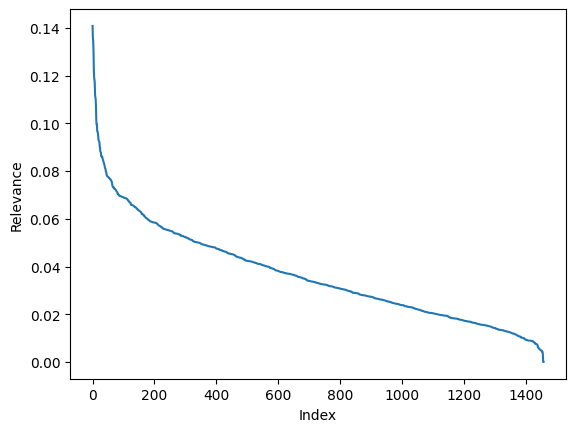

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(df_jobs.shape[0]), sorted_df_jobs.Relevance.values)
plt.xlabel('Index')
plt.ylabel('Relevance')
plt.show()

Ranked jobs postings indices plotted vs relevance. Lower indices indicate higher relevance.  
The relevance is equal to the cosine similarity between each job and existing_skills. This relevance drop rapidly at an index of approximately 60.

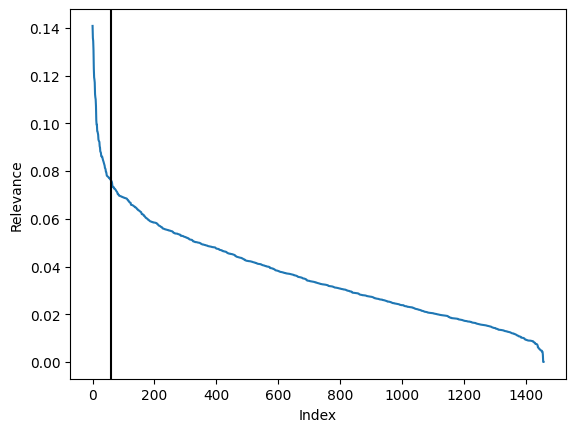

In [19]:
plt.plot(range(df_jobs.shape[0]), sorted_df_jobs.Relevance.values)
plt.xlabel('Index')
plt.ylabel('Relevance')
plt.axvline(60,c='k')
plt.show()

In [20]:
for title in sorted_df_jobs[40:60].Title.values:
    print(title)

Data Scientist III - Pasadena, CA 91101
Global Data Engineer - Boston, MA
Data Analyst and Data Scientist - Summit, NJ
Data Scientist - Generalist - Glendale, CA
Data Scientist - Seattle, WA
IT Data Scientist - Contract - Riverton, UT
Data Scientist (Analytic Consultant 4) - San Francisco, CA
Data Scientist - Seattle, WA
Data Science & Tagging Analyst - Bethesda, MD 20814
Data Scientist - New York, NY
Senior Data Scientist - Los Angeles, CA
Principal Statistician - Los Angeles, CA
Senior Data Analyst - Los Angeles, CA
Data Scientist - Aliso Viejo, CA 92656
Data Engineer - Seattle, WA
Data Scientist - Digital Factory - Tampa, FL 33607
Data Scientist - Grapevine, TX 76051
Data Scientist - Bioinformatics - Denver, CO 80221
EPIDEMIOLOGIST - Los Angeles, CA
Data Scientist - Bellevue, WA


In [21]:
for title in sorted_df_jobs[60:80].Title.values:
    print(title)

Data Scientist - Aliso Viejo, CA
Data Scientist and Visualization Specialist - Santa Clara Valley, CA 95014
Data Scientist - Los Angeles, CA
Data Scientist Manager - NEW YORK LOCATION! - New York, NY 10036
Data Science Intern - San Francisco, CA 94105
Research Data Analyst - San Francisco, CA
Sr Data Scientist (Analytic Consultant 5) - San Francisco, CA
Data Scientist, Media Manipulation - Cambridge, MA
Manager, Data Science, Programming and Visualization - Boston, MA
Data Scientist in Broomfield, CO - Broomfield, CO
Senior Data Scientist - Executive Projects and New Solutions - Foster City, CA
Manager of Data Science - Burbank California - Burbank, CA
Data Scientist Manager - Hiring in Burbank! - Burbank, CA
Data Scientists needed in NY - Senior Consultants and Managers! - New York, NY 10036
Data Scientist - Menlo Park, CA
Data Engineer - Santa Clara, CA
Data Scientist - Remote
Data Scientist I-III - Phoenix, AZ 85021
SWE Data Scientist - Santa Clara Valley, CA 95014
Health Science Sp

In [22]:
import re

def percent_relevant_titles(df):
    regex_relevant = re.compile(r'Data (Scien|Analy)',
                                flags=re.IGNORECASE)
    regex_irrelevant = re.compile(r'\b(Manage)',
                                  flags=re.IGNORECASE)
    match_count = len([title for title in df.Title if 
                       regex_relevant.search(title) and
                       not regex_irrelevant.search(title)])
    percent = 100 * match_count / df.shape[0]
    return percent

percent = percent_relevant_titles(sorted_df_jobs[60:80])
print(f"Approximately {percent:.2f}% of job title between indices 60 - 80 are relevant")

Approximately 65.00% of job title between indices 60 - 80 are relevant


Perhaps the percentage will drop if we sample next 20 jobs across an index range of 80-100. Let's check

In [23]:
percent = percent_relevant_titles(sorted_df_jobs[80:100])
print(f"Approximately {percent:.2f}% of job title between indices 80 - 100 are relevant")

Approximately 80.00% of job title between indices 80 - 100 are relevant


In [ ]:
# Plotting percent relevance across all title samples
